In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.3
!pip install opencv-python==4.6.0.66

## import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
np.random.seed(123)
torch.use_deterministic_algorithms(True)

## define model architecture

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [5]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [6]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))


## create data loaders

In [7]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

## define optimizer and run training epochs

In [8]:
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [9]:
for epoch in range(1, 20):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.294348
epoch: 1 [320/60000 (1%)]	 training loss: 1.743703
epoch: 1 [640/60000 (1%)]	 training loss: 1.272358
epoch: 1 [960/60000 (2%)]	 training loss: 1.964490
epoch: 1 [1280/60000 (2%)]	 training loss: 0.411745
epoch: 1 [1600/60000 (3%)]	 training loss: 0.666613
epoch: 1 [1920/60000 (3%)]	 training loss: 0.852746
epoch: 1 [2240/60000 (4%)]	 training loss: 0.280735
epoch: 1 [2560/60000 (4%)]	 training loss: 0.608666
epoch: 1 [2880/60000 (5%)]	 training loss: 0.459875
epoch: 1 [3200/60000 (5%)]	 training loss: 0.200465
epoch: 1 [3520/60000 (6%)]	 training loss: 0.381452
epoch: 1 [3840/60000 (6%)]	 training loss: 0.143269
epoch: 1 [4160/60000 (7%)]	 training loss: 0.695926
epoch: 1 [4480/60000 (7%)]	 training loss: 0.592977
epoch: 1 [4800/60000 (8%)]	 training loss: 0.347031
epoch: 1 [5120/60000 (9%)]	 training loss: 0.402775
epoch: 1 [5440/60000 (9%)]	 training loss: 0.525813
epoch: 1 [5760/60000 (10%)]	 training loss: 0.373715
epoch: 1 [6080/60

## run inference on trained model

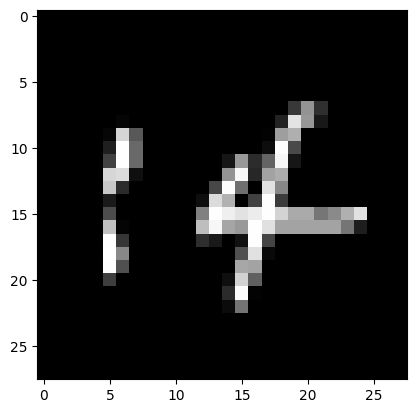

In [10]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [11]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 4
Ground truth is : 4


### visualize filters

In [12]:
model_children_list = list(model.children())
convolutional_layers = []
model_parameters = []
model_children_list

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
 Dropout2d(p=0.1, inplace=False),
 Dropout2d(p=0.25, inplace=False),
 Linear(in_features=4608, out_features=64, bias=True),
 Linear(in_features=64, out_features=10, bias=True)]

In [13]:
for i in range(len(model_children_list)):
    if type(model_children_list[i]) == nn.Conv2d:
        model_parameters.append(model_children_list[i].weight)
        convolutional_layers.append(model_children_list[i])

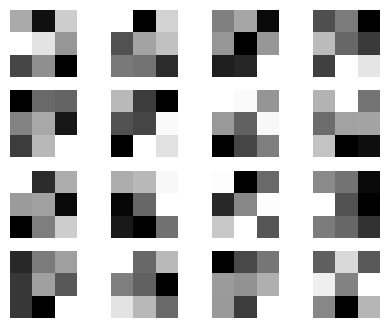

In [14]:
plt.figure(figsize=(5, 4))
for i, flt in enumerate(model_parameters[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(flt[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

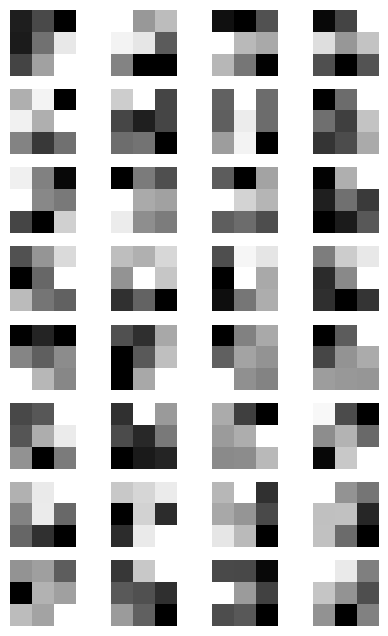

In [15]:
plt.figure(figsize=(5, 8))
for i, flt in enumerate(model_parameters[1]):
    plt.subplot(8, 4, i+1)
    plt.imshow(flt[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

### visualize feature maps

In [16]:
per_layer_results = [convolutional_layers[0](sample_data)]
for i in range(1, len(convolutional_layers)):
    per_layer_results.append(convolutional_layers[i](per_layer_results[-1]))

torch.Size([16, 26, 26])


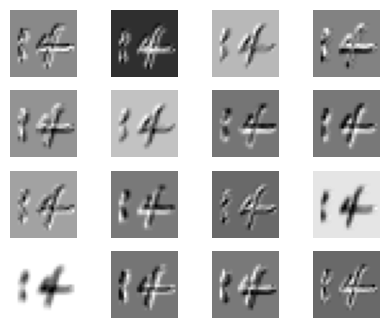

In [17]:
plt.figure(figsize=(5, 4))
layer_visualisation = per_layer_results[0][0, :, :, :]
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
for i, flt in enumerate(layer_visualisation):
    plt.subplot(4, 4, i + 1)
    plt.imshow(flt, cmap='gray')
    plt.axis("off")
plt.show()

torch.Size([32, 24, 24])


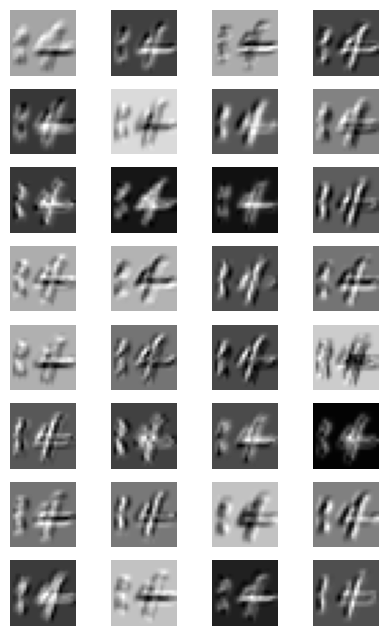

In [18]:
plt.figure(figsize=(5, 8))
layer_visualisation = per_layer_results[1][0, :, :, :]
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
for i, flt in enumerate(layer_visualisation):
    plt.subplot(8, 4, i + 1)
    plt.imshow(flt, cmap='gray')
    plt.axis("off")
plt.show()